In [ ]:
!pip install gmsdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import (DBSCAN, KMeans, AgglomerativeClustering,
                              OPTICS, SpectralClustering)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
                              calinski_harabasz_score, adjusted_rand_score)
from gmsdb import GMSDB

In [ ]:
def optimize_hyperparams(X, param_range, create_model_fn, score_fn, maximize=True, ground_truth=None, gt_indices=None):
    best_score = float('-inf') if maximize else float('inf')
    best_param = None
    best_labels = None
    param_list = []
    score_list = []

    for param_val in param_range:
        model = create_model_fn(param_val)
        labels = model.fit_predict(X)

        if ground_truth is not None and gt_indices is not None:
            metric_val = score_fn(labels[gt_indices], ground_truth[gt_indices])
            is_better = (metric_val > best_score) if maximize else (metric_val < best_score)
            if is_better:
                best_score = metric_val
                best_param = param_val
                best_labels = labels
            param_list.append(param_val)
            score_list.append(metric_val)
        elif len(np.unique(labels)) > 1:
            metric_val = score_fn(X, labels, model)
            is_better = (metric_val > best_score) if maximize else (metric_val < best_score)
            if is_better:
                best_score = metric_val
                best_param = param_val
                best_labels = labels
            param_list.append(param_val)
            score_list.append(metric_val)

    return best_param, best_score, best_labels, param_list, score_list

In [ ]:
def plot_results(X, labels, title, n_clusters):
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], s=2, c=labels, cmap='tab20')
    plt.title(f"{title}, кластеров – {n_clusters}")
    plt.show()

def plot_metric_curve(param_list, score_list, method_name, param_name, metric_name):
    plt.figure(figsize=(6, 4))
    plt.plot(param_list, score_list, marker='o')
    plt.title(method_name)
    plt.xlabel(param_name)
    plt.ylabel(metric_name)
    plt.grid(True, alpha=0.3)
    plt.show()

Загружено 10300 точек


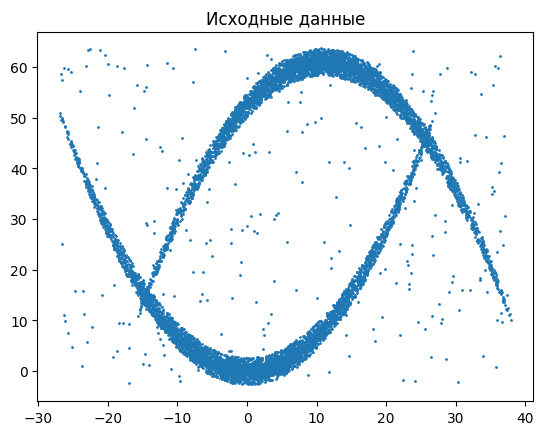

In [ ]:
dataset = np.loadtxt('hs.dat')
print(f'Загружено {dataset.shape[0]} точек')
plt.scatter(dataset[:, 0], dataset[:, 1], s=1)
plt.title('Исходные данные')
plt.show()

In [ ]:
# Для корректной работы некоторых метрик, нужно взять 10% данных и разметить их с помощью GMsDB
gmsdb_model = GMSDB(n_components=20)
gmsdb_gt_labels = gmsdb_model.fit_predict(dataset)
np.random.seed(42)
perm = np.random.permutation(len(gmsdb_gt_labels))
subset_indices = perm[:int(0.1 * len(gmsdb_gt_labels))]
true_labels = gmsdb_gt_labels
print(f'Выбрано {len(subset_indices)} точек для ground truth ({100*len(subset_indices)/len(dataset):.1f}%)')

Выбрано 1030 точек для ground truth (10.0%)


In [ ]:
def gap_statistic(X, labels, model):
    n_clusters = len(np.unique(labels[labels != -1]))
    if n_clusters <= 1:
        return -np.inf

    inertia = model.inertia_

    n_refs = 10
    ref_inertias = []
    for _ in range(n_refs):
        X_ref = np.random.uniform(X.min(axis=0), X.max(axis=0), size=X.shape)
        km_ref = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        km_ref.fit(X_ref)
        ref_inertias.append(km_ref.inertia_)

    gap = np.log(np.mean(ref_inertias)) - np.log(inertia)
    return gap


KMeans - Gap Statistic
Лучший k = 20, Gap Statistic = 1.365


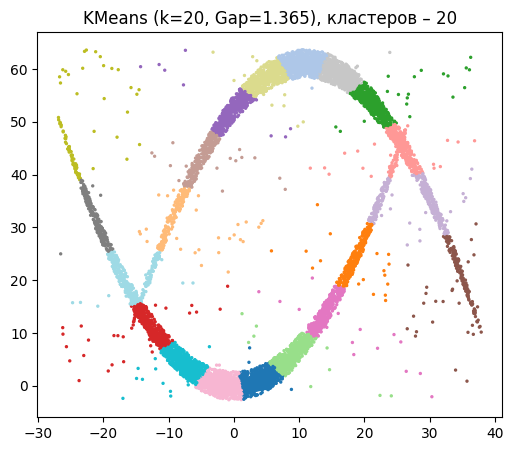

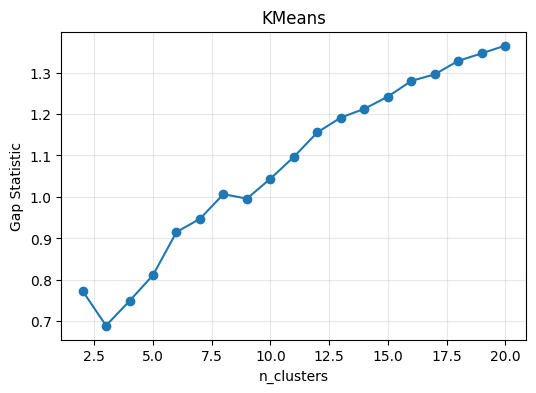

In [ ]:
print('\nKMeans - Gap Statistic')
best_k, best_gap, best_km_labels, k_list, gap_list = optimize_hyperparams(
    dataset,
    range(2, 21),
    lambda k: KMeans(n_clusters=k, n_init=10, random_state=42),
    gap_statistic,
    maximize=True
)

n_km_clusters = len(np.unique(best_km_labels))
print(f'Лучший k = {best_k}, Gap Statistic = {best_gap:.3f}')
plot_results(dataset, best_km_labels, f'KMeans (k={best_k}, Gap={best_gap:.3f})', n_km_clusters)
plot_metric_curve(k_list, gap_list, 'KMeans', 'n_clusters', 'Gap Statistic')


AgglomerativeClustering - Adjusted Rand Score
Лучший n_clusters = 2, ARI = 0.748


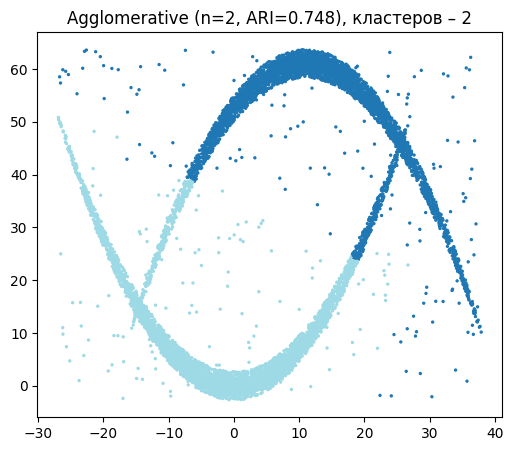

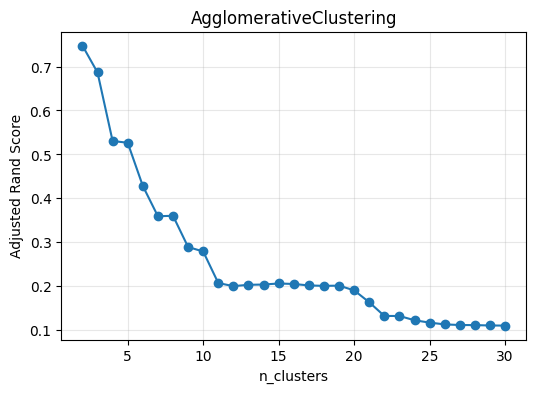

In [ ]:
print('\nAgglomerativeClustering - Adjusted Rand Score')
best_n_agg, best_db, best_agg_labels, n_agg_list, db_list = optimize_hyperparams(
    dataset,
    range(2, 31),
    lambda n: AgglomerativeClustering(n_clusters=n),
    adjusted_rand_score,
    maximize=True,
    ground_truth=true_labels,
    gt_indices=subset_indices
)

n_agg_clusters = len(np.unique(best_agg_labels))
print(f'Лучший n_clusters = {best_n_agg}, ARI = {best_db:.3f}')
plot_results(dataset, best_agg_labels, f'Agglomerative (n={best_n_agg}, ARI={best_db:.3f})', n_agg_clusters)
plot_metric_curve(n_agg_list, db_list, 'AgglomerativeClustering', 'n_clusters', 'Adjusted Rand Score')


GaussianMixture - BIC
Лучший n_components = 20, BIC = 127817.14


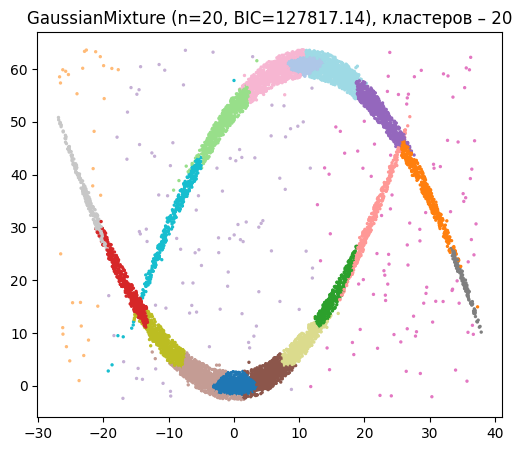

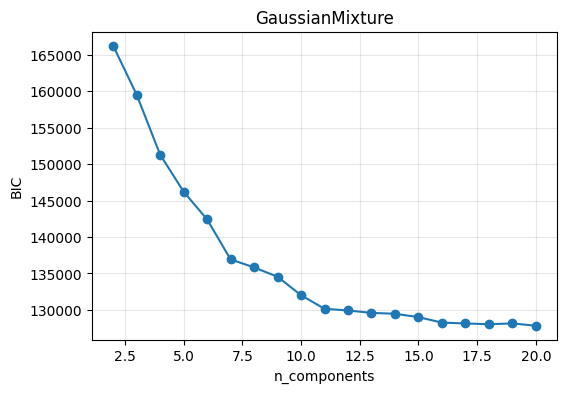

In [ ]:
print('\nGaussianMixture - BIC')
best_n_gmm, best_bic, best_gmm_labels, n_gmm_list, bic_list = optimize_hyperparams(
    dataset,
    range(1, 21),
    lambda n: GaussianMixture(n_components=n, random_state=42),
    lambda X, labels, model: model.bic(X),
    maximize=False
)

n_gmm_clusters = len(np.unique(best_gmm_labels))
print(f'Лучший n_components = {best_n_gmm}, BIC = {best_bic:.2f}')
plot_results(dataset, best_gmm_labels, f'GaussianMixture (n={best_n_gmm}, BIC={best_bic:.2f})', n_gmm_clusters)
plot_metric_curve(n_gmm_list, bic_list, 'GaussianMixture', 'n_components', 'BIC')


SpectralClustering - Silhouette
Лучший n_clusters = 2, Silhouette = 0.647


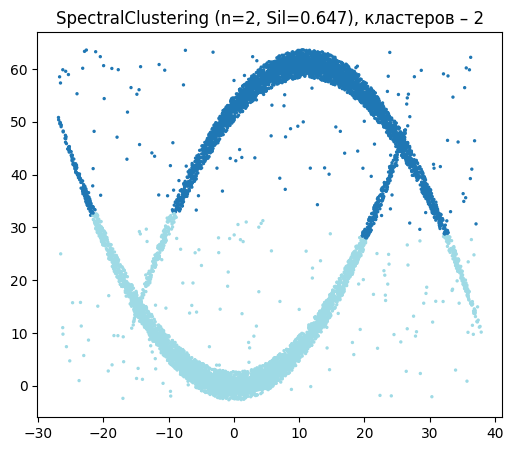

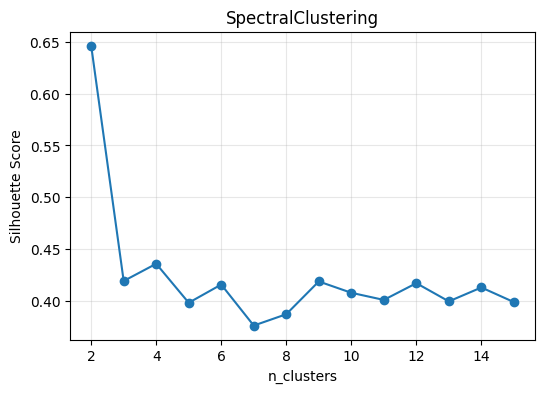

In [ ]:
print('\nSpectralClustering - Silhouette')
best_n_spec, best_sil, best_spec_labels, n_spec_list, sil_list = optimize_hyperparams(
    dataset,
    range(2, 16),
    lambda n: SpectralClustering(n_clusters=n, affinity='nearest_neighbors', n_init=5, random_state=42),
    lambda X, labels, model: silhouette_score(X, labels),
    maximize=True
)

n_spec_clusters = len(np.unique(best_spec_labels))
print(f'Лучший n_clusters = {best_n_spec}, Silhouette = {best_sil:.3f}')
plot_results(dataset, best_spec_labels, f'SpectralClustering (n={best_n_spec}, Sil={best_sil:.3f})', n_spec_clusters)
plot_metric_curve(n_spec_list, sil_list, 'SpectralClustering', 'n_clusters', 'Silhouette Score')


DBSCAN - Calinski-Harabasz
Лучший eps = 0.800, Calinski-Harabasz = 10.04


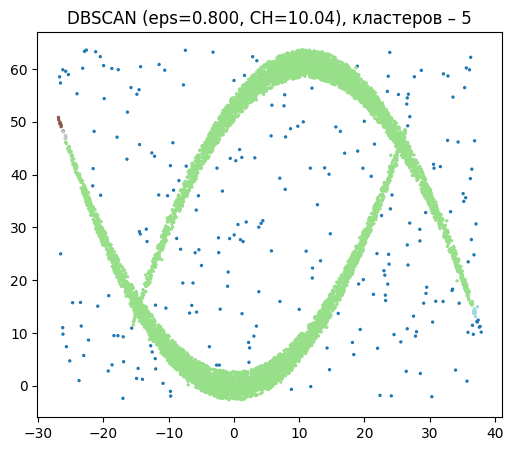

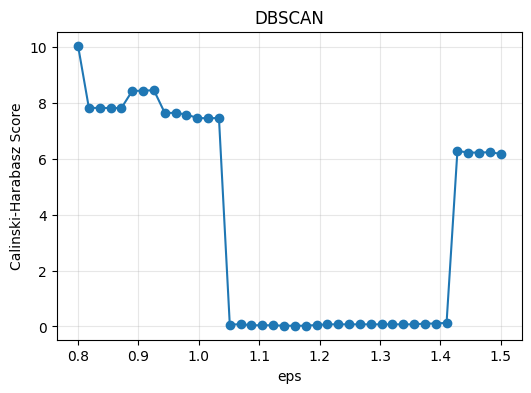

In [ ]:
print('\nDBSCAN - Calinski-Harabasz')
best_eps, best_ch, best_db_labels, eps_list, ch_list = optimize_hyperparams(
    dataset,
    np.linspace(0.8, 1.5, 40),
    lambda e: DBSCAN(eps=e, min_samples=5),
    lambda X, labels, model: calinski_harabasz_score(X, labels),
    maximize=True
)

n_db_clusters = len(np.unique(best_db_labels))
print(f'Лучший eps = {best_eps:.3f}, Calinski-Harabasz = {best_ch:.2f}')
plot_results(dataset, best_db_labels, f'DBSCAN (eps={best_eps:.3f}, CH={best_ch:.2f})', n_db_clusters)
plot_metric_curve(eps_list, ch_list, 'DBSCAN', 'eps', 'Calinski-Harabasz Score')


OPTICS - Adjusted Rand Score
Лучший min_samples = 59, ARI = 0.852


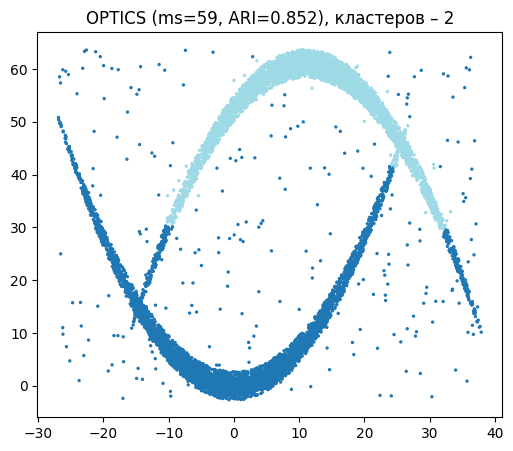

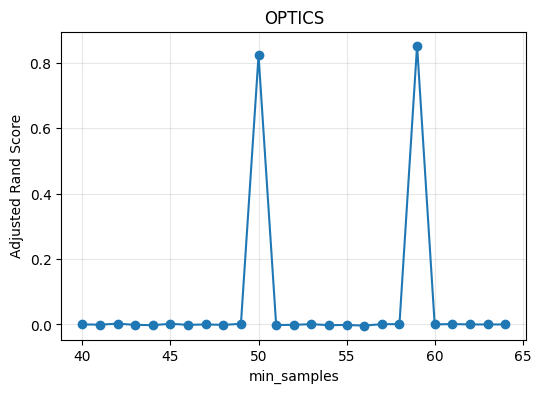

In [ ]:
print('\nOPTICS - Adjusted Rand Score')
best_ms, best_ari, best_opt_labels, ms_list, ari_list = optimize_hyperparams(
    dataset,
    range(40, 65),
    lambda ms: OPTICS(min_samples=ms),
    adjusted_rand_score,
    maximize=True,
    ground_truth=true_labels,
    gt_indices=subset_indices
)

n_opt_clusters = len(np.unique(best_opt_labels))
print(f'Лучший min_samples = {best_ms}, ARI = {best_ari:.3f}')
plot_results(dataset, best_opt_labels, f'OPTICS (ms={best_ms}, ARI={best_ari:.3f})', n_opt_clusters)
plot_metric_curve(ms_list, ari_list, 'OPTICS', 'min_samples', 'Adjusted Rand Score')


GMsDB
GMsDB: кластеров = 3


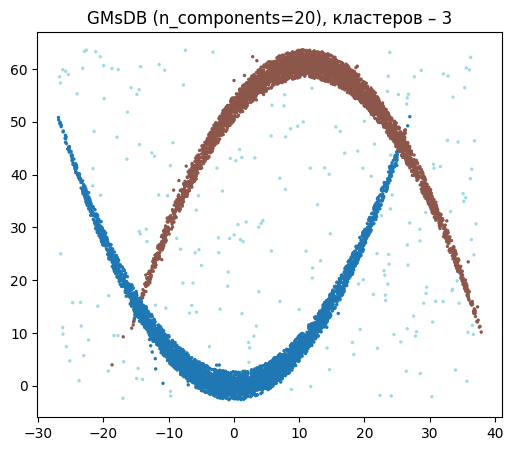

In [ ]:
print('\nGMsDB')
gmsdb_model = GMSDB(n_components=20)
gmsdb_labels = gmsdb_model.fit_predict(dataset)
n_gmsdb_clusters = len(np.unique(gmsdb_labels))
print(f'GMsDB: кластеров = {n_gmsdb_clusters}')
plot_results(dataset, gmsdb_labels, 'GMsDB (n_components=20)', n_gmsdb_clusters)

In [ ]:
print('\nИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ')

results = [
    ('KMeans', n_km_clusters, f'Gap={best_gap:.3f}', f'k={best_k}'),
    ('Agglomerative', n_agg_clusters, f'ARI={best_db:.3f}', f'n={best_n_agg}'),
    ('GaussianMixture', n_gmm_clusters, f'BIC={best_bic:.2f}', f'n={best_n_gmm}'),
    ('SpectralClustering', n_spec_clusters, f'Silhouette={best_sil:.3f}', f'n={best_n_spec}'),
    ('DBSCAN', n_db_clusters, f'CH={best_ch:.2f}', f'eps={best_eps:.3f}'),
    ('OPTICS', n_opt_clusters, f'ARI={best_ari:.3f}', f'ms={best_ms}'),
    ('GMsDB', n_gmsdb_clusters, '-', 'n=20')
]

for method, n_clust, metric, params in results:
    print(f'{method:20s} | Кластеров: {n_clust:3d} | Метрика: {metric:20s} | Параметры: {params}')


ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
KMeans               | Кластеров:  20 | Метрика: Gap=1.365            | Параметры: k=20
Agglomerative        | Кластеров:   2 | Метрика: ARI=0.748            | Параметры: n=2
GaussianMixture      | Кластеров:  20 | Метрика: BIC=127817.14        | Параметры: n=20
SpectralClustering   | Кластеров:   2 | Метрика: Silhouette=0.647     | Параметры: n=2
DBSCAN               | Кластеров:   5 | Метрика: CH=10.04             | Параметры: eps=0.800
OPTICS               | Кластеров:   2 | Метрика: ARI=0.852            | Параметры: ms=59
GMsDB                | Кластеров:   3 | Метрика: -                    | Параметры: n=20
